# Sydney Air BnB Price Prediction Modeling (Part 2)
## Institute of Data Capstone Project: Estimating Annual Earnings in Sydney's Housing Rental Market
### Wendy Maria D'Sa
##### NOTE: The below is just an overview. Please see Project documentation for detailed description and processes.

## What is the goal of the project?
* **Business Goal:** Assisting investment property owners estimate earnings either through short-term(180-days) or long-term rentals(> 180 days - effectively 1 yr and above)
* **Data Goal:** Predicting AirBnB pricing for different types of properties across different geographical locations across Sydney. This pricing will help stakeholders estimate earning on short-term rentals.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
import statsmodels.graphics.gofplots as sm
import math
from datetime import datetime
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error


from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as XGB
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor

plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark

font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

## Load datafile

In [2]:
model_csv = 'bnb_modeling.csv'
df = pd.read_csv(model_csv)

# To view all columns
# pd.set_option('display.max_columns', len(bnb_modeling.columns)) 
df.head(2)

,id,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,latitude,...,outdoor_space,essentials,host_greeting,hot_water,heating,internet,long_term_stays,private_entrance,self_check_in,accessible
0,14250,1,10.0,1,90.0,0,2.0,Balgowlah,Northern Beaches,-33.800929,...,0,1,0,1,1,1,0,0,0,0
1,20865,1,9.0,1,100.0,1,2.0,Balmain,Inner West,-33.859072,...,0,1,0,0,1,1,0,1,0,0


In [3]:
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns")

The dataset contains 22396 rows and 66 columns


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22396 entries, 0 to 22395
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           22396 non-null  int64  
 1   host_location                22396 non-null  int64  
 2   host_experience              22396 non-null  float64
 3   response_time                22396 non-null  int64  
 4   response_rate                22396 non-null  float64
 5   superhost                    22396 non-null  int64  
 6   host_listings                22396 non-null  float64
 7   suburb                       22396 non-null  object 
 8   lga                          22396 non-null  object 
 9   latitude                     22396 non-null  float64
 10  longitude                    22396 non-null  float64
 11  dist_to_cbd                  22396 non-null  float64
 12  cafe_density                 22396 non-null  float64
 13  transport_rating

In [5]:
print(df.isnull().sum())

id                  0
host_location       0
host_experience     0
response_time       0
response_rate       0
                   ..
internet            0
long_term_stays     0
private_entrance    0
self_check_in       0
accessible          0
Length: 66, dtype: int64


In [6]:
# convert id to index
df.set_index('id', inplace=True) 
df.head(3)

,host_location,host_experience,response_time,response_rate,superhost,host_listings,suburb,lga,latitude,longitude,...,outdoor_space,essentials,host_greeting,hot_water,heating,internet,long_term_stays,private_entrance,self_check_in,accessible
id,,,,,,,,,,,,,,,,,,,,,
14250,1,10.0,1,90.0,0,2.0,Balgowlah,Northern Beaches,-33.800929,151.261722,...,0,1,0,1,1,1,0,0,0,0
20865,1,9.0,1,100.0,1,2.0,Balmain,Inner West,-33.859072,151.172753,...,0,1,0,0,1,1,0,1,0,0
38073,1,9.0,0,94.0,0,1.0,North Sydney,North Sydney,-33.834429,151.208875,...,0,1,0,0,1,1,0,0,0,0


In [7]:
# convert suburb and lga to category type
df['suburb'] = df['suburb'].astype('category')
df['lga'] = df['lga'].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 65 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   host_location                22396 non-null  int64   
 1   host_experience              22396 non-null  float64 
 2   response_time                22396 non-null  int64   
 3   response_rate                22396 non-null  float64 
 4   superhost                    22396 non-null  int64   
 5   host_listings                22396 non-null  float64 
 6   suburb                       22396 non-null  category
 7   lga                          22396 non-null  category
 8   latitude                     22396 non-null  float64 
 9   longitude                    22396 non-null  float64 
 10  dist_to_cbd                  22396 non-null  float64 
 11  cafe_density                 22396 non-null  float64 
 12  transport_rating             22396 non-null  float64 

## Data Preprocessing
#### 1. Storing additional dataframes and Dropping columns not needed
   * **Dropping suburb since we already have location based feature in the form of LGA & latitude & longitude.**
   * **Storing neighbourhood features in a seperate dataframe**

In [9]:
# create neighbourhood dataframe
neighbourhood_df = df[['suburb', 'lga', 'latitude', 'longitude', 'dist_to_cbd', 'cafe_density', 'transport_rating', 'beach_access', 
                      'cultural_access', 'nat_park_access', 'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price']].copy()

In [10]:
neighbourhood_df.head(3)

,suburb,lga,latitude,longitude,dist_to_cbd,cafe_density,transport_rating,beach_access,cultural_access,nat_park_access,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,price
id,,,,,,,,,,,,,,,,,
14250,Balgowlah,Northern Beaches,-33.800929,151.261722,3.0,4.0,2.5,4.0,2.0,2.0,House,6,3.0,3,3,1,471.0
20865,Balmain,Inner West,-33.859072,151.172753,1.0,5.0,3.5,2.0,5.0,1.0,House,8,2.0,4,4,1,450.0
38073,North Sydney,North Sydney,-33.834429,151.208875,1.0,5.0,3.0,4.0,5.0,1.0,Apartment,2,1.0,1,1,1,159.0


In [11]:
# copy dataframe
processing_df = df.copy()

In [12]:
# drop suburb
processing_df.drop(['suburb'], axis=1, inplace=True)

In [13]:
processing_df.shape

(22396, 64)

### 2. One-hot encode categorical data

In [14]:
new_df = pd.get_dummies(processing_df)

In [15]:
new_df.shape

(22396, 95)

### 3. Check for correlation
   * **There is a strong correlation between review score rating and the individual review categories. We will drop them and just keep the overall review rating.**
   * **There is also higher correlation between price and beds, bedrooms, bathrooms, and accommodates. But, we keep them for the time being as these will most probably be the top features.** 
   * **There is also a correlation of price with security deposit and cleaning fee as well as with property_type house**
   * **We see a negative correlation between price and property_type apartment. This makes sense considering the size restrictions between apartment and houses. You will pay a higher price for a larger house than an apartment. Hence, lower number of apartments at higher price ranges.**

In [16]:
# check correlation between independent and dependent variable
corr = new_df.corr()

# check positive correlation with price
p = corr['price']
pos_corr = p[p > 0.25]
print(pos_corr.sort_values(ascending=False))

price                  1.000000
bedrooms               0.659369
bathrooms              0.656045
accommodates           0.609969
beds                   0.573941
cleaning_fee           0.505417
property_type_House    0.472367
security_deposit       0.469726
Name: price, dtype: float64


In [17]:
# check negative correlation with price
n = corr['price']
neg_corr = n[n < -0.2]
print(neg_corr.sort_values(ascending=False))

review_scores_cleanliness     -0.200887
review_scores_accuracy        -0.203765
review_scores_checkin         -0.204485
review_scores_location        -0.204490
review_scores_communication   -0.206021
review_scores_value           -0.211440
transport_rating              -0.219464
property_type_Apartment       -0.472367
Name: price, dtype: float64


In [18]:
# check correlation between review scores
r = corr['review_scores_rating']
rev = r[r > 0.3]
print(rev.sort_values(ascending=False))

review_scores_rating           1.000000
review_scores_accuracy         0.992338
review_scores_value            0.991078
review_scores_communication    0.990055
review_scores_cleanliness      0.988921
review_scores_checkin          0.988551
review_scores_location         0.986921
Name: review_scores_rating, dtype: float64


In [19]:
# check correlation with spatial features
b = corr['bedrooms']
b_rm = b[b > 0.3]
print(b_rm.sort_values(ascending=False))

bedrooms               1.000000
accommodates           0.843180
beds                   0.813204
bathrooms              0.737557
price                  0.659369
property_type_House    0.640095
cleaning_fee           0.478270
security_deposit       0.370973
Name: bedrooms, dtype: float64


In [20]:
# function for plotting correlation matrix
def correlation_heatmap(df, figsize=(11,9)):
    
    # Set the style of the visualization
    sns.set(style="white")
    
    plt.style.use('fivethirtyeight') #ggplot #fivethirtyeight #seaborn-dark
    font = {'family' : 'Georgia',
        'weight' : 'normal',
        'size'   : 12}
    
    matplotlib.rc('font', **font)
    
    # Create a covariance matrix
    corr = df.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = mcolors.LinearSegmentedColormap.from_list("n",['#e5ae38', '#F0F0F0','#339395'])
    norm = plt.Normalize(vmax=corr[corr == 1.0].max().max(), vmin=corr[corr == -1.0].min().min())
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr == 1.0].max().max(), vmin=corr[corr == -1.0].min().min())
    
    plt.show()

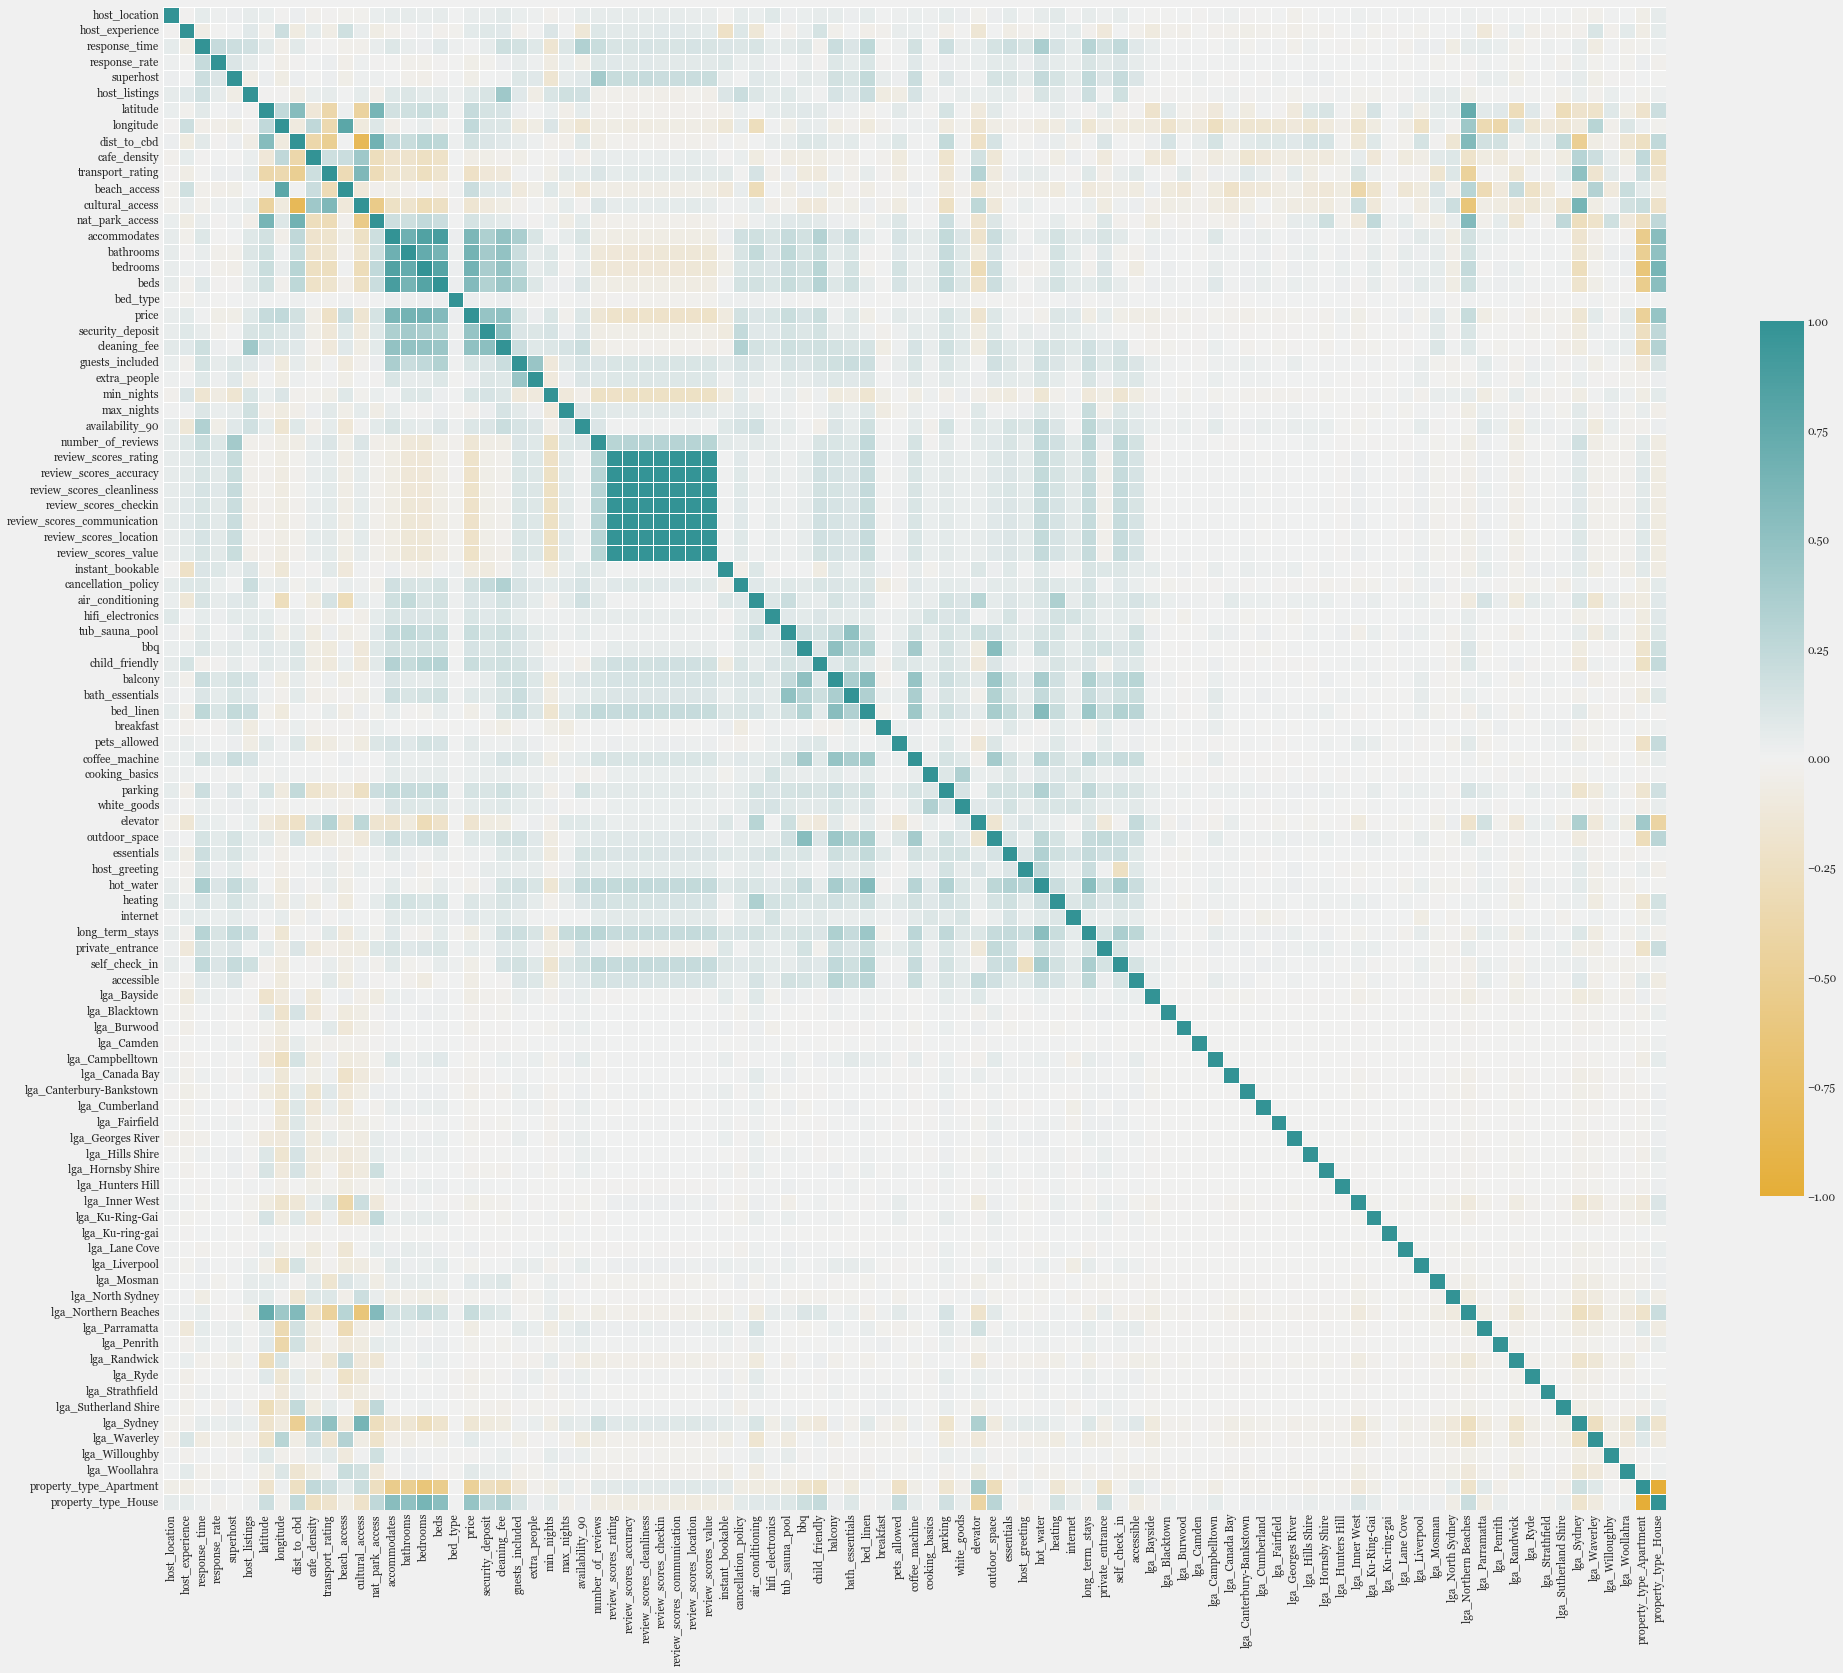

In [21]:
correlation_heatmap(new_df, figsize=(30,30))

In [22]:
# drop reviews sub categories and beds.
new_df.drop(['beds', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1, inplace=True)

In [23]:
new_df.shape

(22396, 88)

In [24]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   host_location             22396 non-null  int64  
 1   host_experience           22396 non-null  float64
 2   response_time             22396 non-null  int64  
 3   response_rate             22396 non-null  float64
 4   superhost                 22396 non-null  int64  
 5   host_listings             22396 non-null  float64
 6   latitude                  22396 non-null  float64
 7   longitude                 22396 non-null  float64
 8   dist_to_cbd               22396 non-null  float64
 9   cafe_density              22396 non-null  float64
 10  transport_rating          22396 non-null  float64
 11  beach_access              22396 non-null  float64
 12  cultural_access           22396 non-null  float64
 13  nat_park_access           22396 non-null  float64
 14 

### 4. Standardising & Normalising
* **Most of the numerical features would need to be normalised as they are either lest or right skewed.**
* **Some features such as cleaning fee, extra people fee and security fee contain a large number of 0s, which means these features are will not normally distributed.**
* **However, the target variable price now appears much more normally distributed.**

In [25]:
num_cols = ['host_experience', 'response_rate', 'host_listings', 'dist_to_cbd', 'cafe_density', 'transport_rating', 'beach_access', 'cultural_access', 'nat_park_access',
           'accommodates', 'bedrooms', 'bathrooms', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'min_nights', 'max_nights', 'availability_90', 'number_of_reviews',
            'review_scores_rating']

In [26]:
for col in num_cols:
    new_df[col] = new_df[col].astype('float64')

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   host_location             22396 non-null  int64  
 1   host_experience           22396 non-null  float64
 2   response_time             22396 non-null  int64  
 3   response_rate             22396 non-null  float64
 4   superhost                 22396 non-null  int64  
 5   host_listings             22396 non-null  float64
 6   latitude                  22396 non-null  float64
 7   longitude                 22396 non-null  float64
 8   dist_to_cbd               22396 non-null  float64
 9   cafe_density              22396 non-null  float64
 10  transport_rating          22396 non-null  float64
 11  beach_access              22396 non-null  float64
 12  cultural_access           22396 non-null  float64
 13  nat_park_access           22396 non-null  float64
 14 

In [28]:
# replacing 0.0 with 0.01
new_df.response_rate.replace(0.0, 0.01, inplace=True)
new_df.security_deposit.replace(0.0, 0.01, inplace=True)
new_df.cleaning_fee.replace(0.0, 0.01, inplace=True)
new_df.extra_people.replace(0.0, 0.01, inplace=True)
new_df.availability_90.replace(0.0, 0.01, inplace=True)
new_df.number_of_reviews.replace(0.0, 0.01, inplace=True)
new_df.review_scores_rating.replace(0.0, 0.01, inplace=True)

In [29]:
# log transforming columns
for col in num_cols:
    new_df[col] = np.log(new_df[col])

In [30]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22396 entries, 14250 to 30592505
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   host_location             22396 non-null  int64  
 1   host_experience           22396 non-null  float64
 2   response_time             22396 non-null  int64  
 3   response_rate             22396 non-null  float64
 4   superhost                 22396 non-null  int64  
 5   host_listings             22396 non-null  float64
 6   latitude                  22396 non-null  float64
 7   longitude                 22396 non-null  float64
 8   dist_to_cbd               22396 non-null  float64
 9   cafe_density              22396 non-null  float64
 10  transport_rating          22396 non-null  float64
 11  beach_access              22396 non-null  float64
 12  cultural_access           22396 non-null  float64
 13  nat_park_access           22396 non-null  float64
 14 

In [31]:
new_df.shape

(22396, 88)

## Model Building
### 1. Splitting  and Scaling Data

In [32]:
X = new_df.drop(['price'], axis=1)
y = new_df.price

In [33]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=123)

### 2. Define Evaluation Functions

In [35]:
def show_metrics(prediction_train, prediction_test, y_train, y_test):
    
    MSE_train = round(metrics.mean_squared_error(y_train, prediction_train), 2)
    MSE_test = round(metrics.mean_squared_error(y_test, prediction_test), 2)
    
    RMSE_train = round(np.sqrt(metrics.mean_squared_error(y_train, prediction_train)), 2)
    RMSE_test = round(np.sqrt(metrics.mean_squared_error(y_test, prediction_test)), 2)
    
    RMSE_ratio_train = round(np.sqrt(metrics.mean_squared_error(y_train, prediction_train)) / np.mean(y_train),3)
    RMSE_ratio_test= round(np.sqrt(metrics.mean_squared_error(y_test, prediction_test)) / np.mean(y_test),3)
    
    R_2_train = round(metrics.explained_variance_score(y_train, prediction_train), 2)
    R_2_test = round(metrics.explained_variance_score(y_test, prediction_test), 2)
    
    metrics_data = pd.DataFrame(data = [MSE_train, MSE_test, RMSE_train, RMSE_test, RMSE_ratio_train, RMSE_ratio_test, R_2_train, R_2_test]).T
    
    metrics_data.columns = ['MSE_train', 'MSE_test', 'RMSE_train', 'RMSE_test', 'RMSE_ratio_train', 'RMSE_ratio_test', 'R_2_train', 'R_2_test']
    
    display(metrics_data)

In [36]:
def analysis(model, X_train, X_test, y_train, y_test):
    
    prediction_test = model.predict(X_test)
    prediction_train = model.predict(X_train)
    
    show_metrics(prediction_train, prediction_test, y_train, y_test)

    plt.figure(figsize=(8,5))
    
    sns.regplot(x = y_test, y = prediction_test, fit_reg=False, color='#339395')
    plt.title('Real and Prediction')
    plt.show()

    plt.figure(figsize=(8,5))
    
    sns.distplot(y_test - prediction_test, bins = 50, color='#339395')
    plt.title('Error variance')
    plt.show()

### 3. Model 1: Random Forest
#### Base Model

In [37]:
%timeit

# random forest base model
model_rf= RandomForestRegressor(n_estimators=500, criterion='mse', random_state=32, n_jobs=-1, max_depth=7)

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.14,0.15,0.38,0.39,0.071,0.073,0.65,0.63


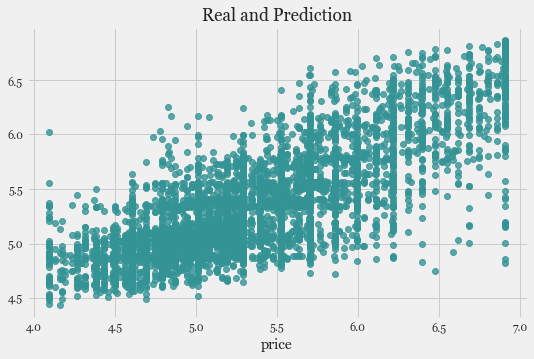

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


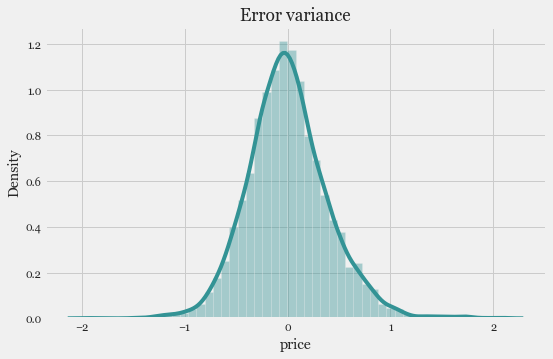

In [38]:
# fit model on train set
model_rf.fit(X_train, y_train)

analysis(model = model_rf, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

#### Feature Importance

In [39]:
feat_rf = pd.DataFrame(model_rf.feature_importances_, columns=['weight'], index=X_train.columns)
feat_rf.sort_values('weight', inplace=True)
pd.set_option('display.max_rows', None)
feat_rf

,weight
lga_Ku-ring-gai,0.000000
bed_type,0.000001
lga_Camden,0.000003
lga_Cumberland,0.000003
lga_Penrith,0.000004
lga_Fairfield,0.000006
lga_Hills Shire,0.000013
lga_Blacktown,0.000014
lga_Ryde,0.000019
lga_Mosman,0.000020


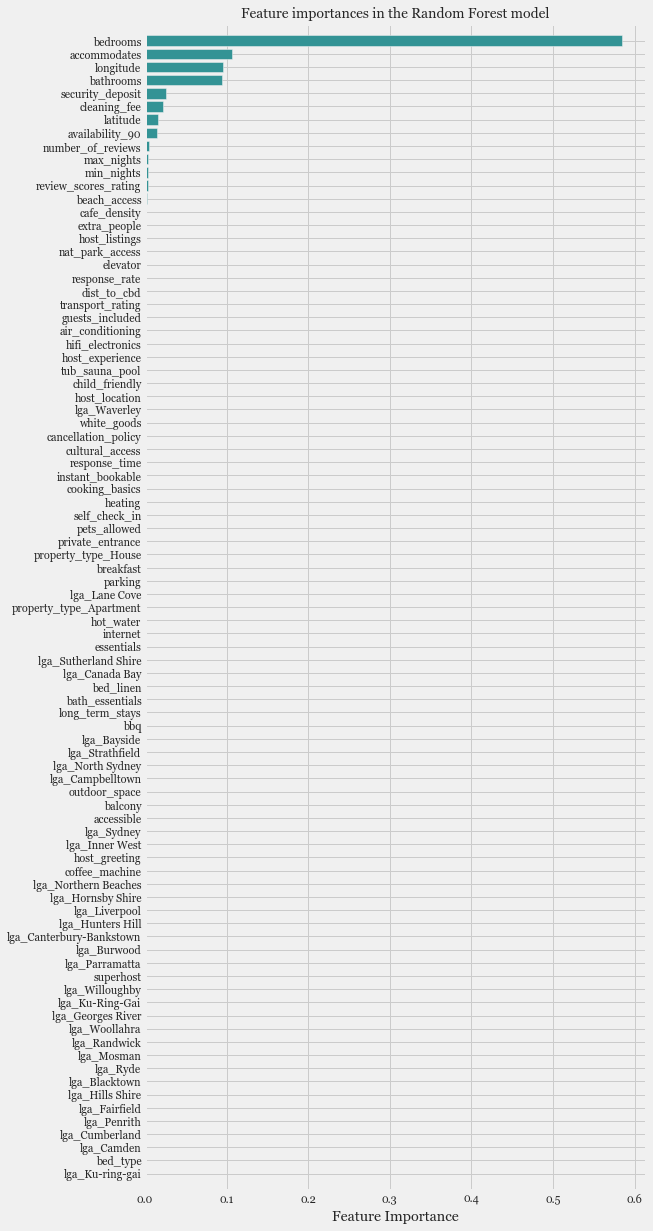

In [40]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(feat_rf.index, feat_rf.weight, align='center', color='#339395') 
plt.title("Feature importances in the Random Forest model", fontsize=14)
plt.xlabel("Feature Importance")
plt.margins(y=0.01)
plt.show()

In [41]:
#extract top 10 features
rf_keep = feat_rf[feat_rf.weight >= 0.004].index
X_train_keep = X_train[rf_keep].copy()
X_test_keep = X_test[rf_keep].copy()

In [42]:
rf_keep

Index(['number_of_reviews', 'availability_90', 'latitude', 'cleaning_fee',
       'security_deposit', 'bathrooms', 'longitude', 'accommodates',
       'bedrooms'],
      dtype='object')

In [43]:
X_train_keep.head()

,number_of_reviews,availability_90,latitude,cleaning_fee,security_deposit,bathrooms,longitude,accommodates,bedrooms
21387,-1.406041,0.935993,-0.599603,0.625843,0.813915,1.013154,-0.081011,0.553612,0.224556
17112,0.882744,0.606874,-0.540992,0.338983,0.661975,1.013154,-0.459712,0.553612,1.019639
2395,-1.406041,-1.370918,-0.411246,0.519972,0.833655,-0.698060,0.214229,-1.259372,-1.134646
6166,1.648746,0.929005,-0.130376,0.338983,-1.193590,-0.698060,-0.199456,0.112097,-1.134646
16023,0.363430,-1.370918,-0.154727,0.205601,-1.193590,-0.698060,0.059446,-1.259372,-1.134646


#### Model with important features: R^2 didn't change much

In [44]:
model_rf2 = RandomForestRegressor(n_estimators=500, criterion='mse', random_state=32, n_jobs=-1, max_depth=7)

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.14,0.15,0.38,0.39,0.071,0.073,0.64,0.63


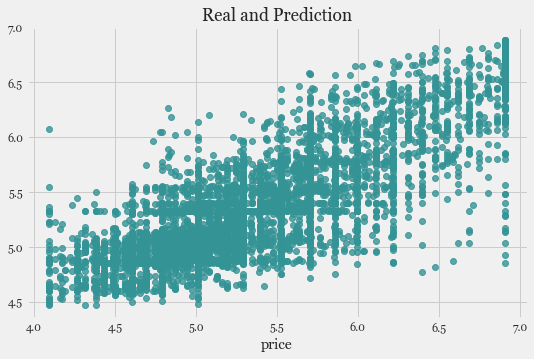

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


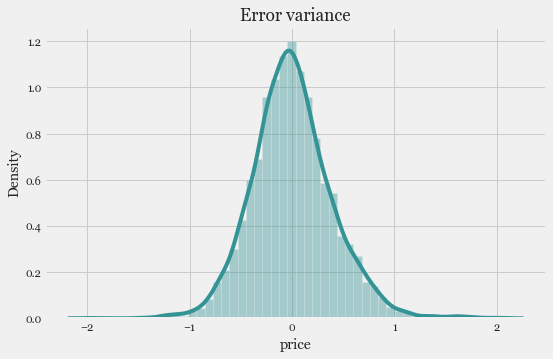

In [45]:
# fit model on train set
model_rf2.fit(X_train_keep, y_train)

analysis(model = model_rf2, X_train = X_train_keep, X_test = X_test_keep, y_train = y_train, y_test = y_test)

#### Hyper parameter Tuning

In [46]:
rf_params = {
    "n_estimators":[500, 800, 1000, 1200],
    "max_depth":[4, 6, 7, 8],
    "min_samples_leaf":[4, 6, 10], 
    "min_samples_split":[5, 7, 10, 15]
}

hyper_rf = RandomizedSearchCV(RandomForestRegressor(), rf_params, n_iter=15, n_jobs=-1, cv=5, verbose=3, random_state=123)
hyper_rf.fit(X_train_keep, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 7, 8],
                                        'min_samples_leaf': [4, 6, 10],
                                        'min_samples_split': [5, 7, 10, 15],
                                        'n_estimators': [500, 800, 1000, 1200]},
                   random_state=123, verbose=3)

In [47]:
print(hyper_rf.best_params_)

{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 8}


#### Model with Hyper Changed Hyper Parameters: Train & Test score improves

In [48]:
model_rf3 = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=32, n_jobs=-1, max_depth=10, min_samples_split=4, min_samples_leaf=6)

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.12,0.14,0.34,0.38,0.064,0.071,0.71,0.66


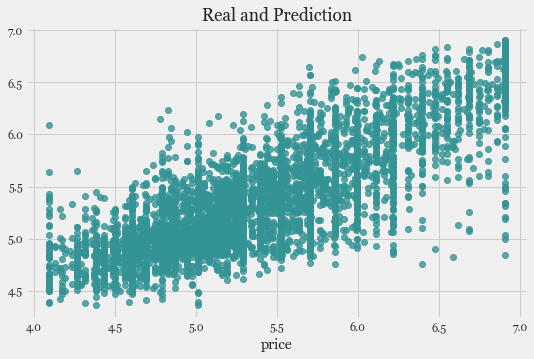

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


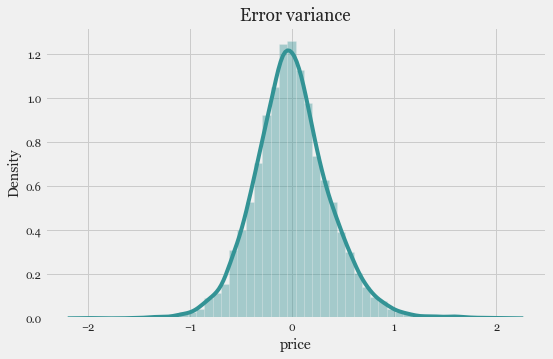

In [49]:
# fit model on train set
model_rf3.fit(X_train_keep, y_train)

analysis(model = model_rf3, X_train = X_train_keep, X_test = X_test_keep, y_train = y_train, y_test = y_test)

In [50]:
y_pred_tr = model_rf3.predict(X_train_keep)

In [51]:
pred_train_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_tr.flatten()})
pred_train_df.head()

,Actual,Predicted
id,,
30217392,5.247024,5.272787
25746635,5.313206,5.571793
5205390,5.273000,5.044792
11895147,5.293305,5.061227
24051333,5.525453,4.845151


In [52]:
#comparison
first20_pred = pred_train_df.head(20).copy()
first20_pred.reset_index(inplace=True)
first20_pred['id'] = first20_pred['id'].astype('str')

first20_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         20 non-null     object 
 1   Actual     20 non-null     float64
 2   Predicted  20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes


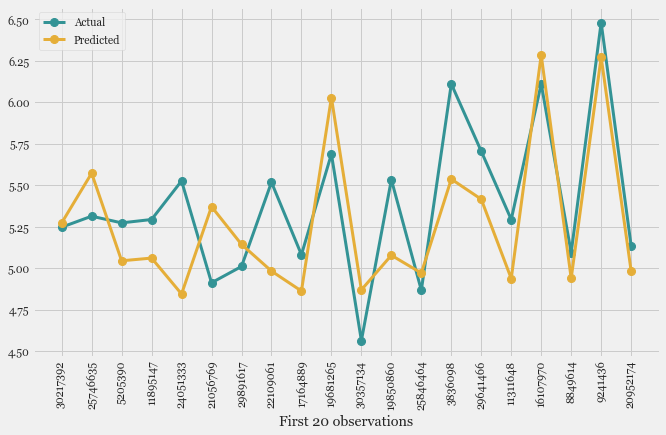

In [53]:
plt.figure(figsize=(10,6))
plt.plot(first20_pred.id, first20_pred.Actual, marker='o', markersize=8, linewidth=3, label='Actual', color='#339395')
plt.plot(first20_pred.id, first20_pred.Predicted, marker='o', markersize=8, linewidth=3, label='Predicted', color='#e5ae38')
plt.xlabel('First 20 observations')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

### 4. Model 2: XG Boost
#### Base Model

In [54]:
# XGBoost base model
model_xgb = XGB.XGBRegressor(objective ='reg:linear', n_estimators=500, max_depth=5, learning_rate=0.01, n_jobs=-1, random_state=32)

[15:24:15] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.12,0.13,0.34,0.36,0.064,0.068,0.71,0.68


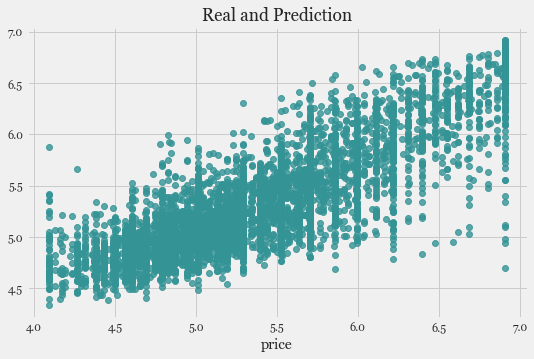

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


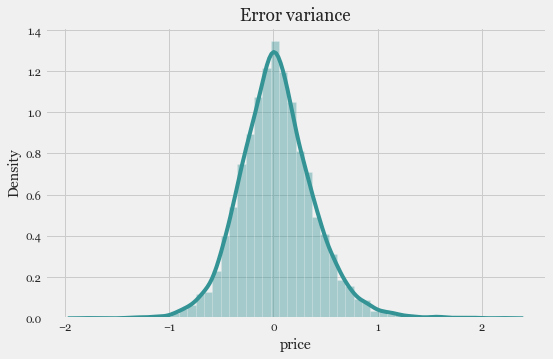

In [55]:
# fit model on train set
model_xgb.fit(X_train, y_train)

analysis(model = model_xgb, X_train = X_train, X_test = X_test, y_train = y_train, y_test =  y_test)

#### Feature Importance

In [56]:
feat_xgb = pd.DataFrame(model_xgb.feature_importances_, columns=['weight'], index=X_train.columns)
feat_xgb.sort_values('weight', inplace=True)
feat_xgb

,weight
property_type_House,0.000000
lga_Camden,0.000000
lga_Hunters Hill,0.000000
lga_Ku-ring-gai,0.000000
lga_Fairfield,0.000000
lga_Penrith,0.000077
lga_Mosman,0.000161
lga_Ryde,0.000330
lga_Inner West,0.000629
lga_Lane Cove,0.000668


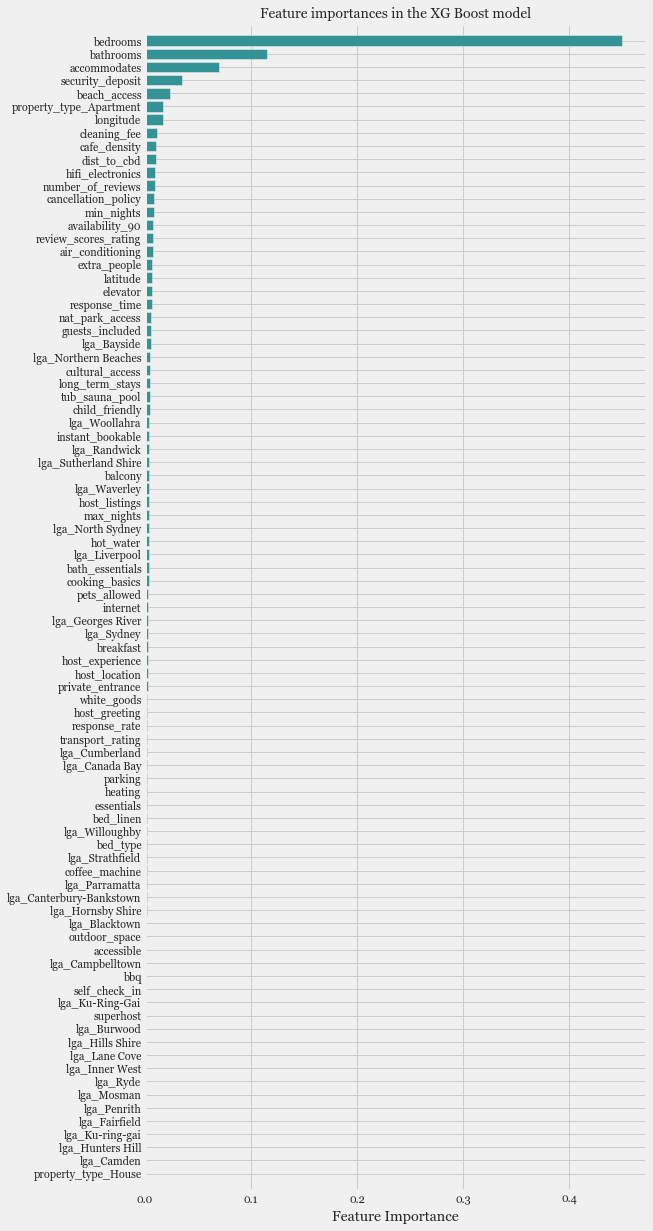

In [57]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(feat_xgb.index, feat_xgb.weight, align='center', color='#339395') 
plt.title("Feature importances in the XG Boost model", fontsize=14)
plt.xlabel("Feature Importance")
plt.margins(y=0.01)
plt.show()

In [58]:
#extract top 10 features and latitude which is ranked 19 since we cannot operate longitude w/o latitude so we extract till latitude
xgb_feat_keep = feat_xgb[feat_xgb.weight >= 0.0067].index
X_train_xgb_keep = X_train[xgb_feat_keep].copy()
X_test_xgb_keep = X_test[xgb_feat_keep].copy()

xgb_feat_keep

Index(['latitude', 'extra_people', 'air_conditioning', 'review_scores_rating',
       'availability_90', 'min_nights', 'cancellation_policy',
       'number_of_reviews', 'hifi_electronics', 'dist_to_cbd', 'cafe_density',
       'cleaning_fee', 'longitude', 'property_type_Apartment', 'beach_access',
       'security_deposit', 'accommodates', 'bathrooms', 'bedrooms'],
      dtype='object')

In [59]:
X_test_xgb_keep.head()

,latitude,extra_people,air_conditioning,review_scores_rating,availability_90,min_nights,cancellation_policy,number_of_reviews,hifi_electronics,dist_to_cbd,cafe_density,cleaning_fee,longitude,property_type_Apartment,beach_access,security_deposit,accommodates,bathrooms,bedrooms
16027,-0.173945,1.389570,0.989164,0.643526,0.738946,-0.570956,0.963774,1.033362,0.296787,-1.049845,0.452695,0.506578,0.059571,0.662612,0.260596,0.608073,-1.259372,-0.698060,-1.134646
5085,-0.596902,-0.689963,0.989164,-1.520063,-1.370918,-0.036513,0.963774,-1.406041,0.296787,-1.049845,0.452695,-1.884951,-0.560151,0.662612,-0.293915,-1.193590,0.914355,2.014150,1.019639
13456,0.500885,-0.689963,-1.010955,-1.520063,-1.370918,1.080310,-1.037588,-1.406041,0.296787,-1.049845,0.452695,-1.884951,0.157636,-1.509180,0.260596,-1.193590,1.483566,2.014150,1.583759
13670,1.989536,-0.689963,0.989164,-1.520063,-1.370918,2.084886,-1.037588,-1.406041,0.296787,1.864468,-0.426281,0.426840,1.080385,0.662612,0.690709,0.661975,-1.259372,1.013154,-1.134646
16926,-0.317878,-0.689963,-1.010955,0.651512,0.825939,-1.484592,-1.037588,1.021195,0.296787,-1.049845,0.452695,0.544858,-0.054059,0.662612,0.260596,0.737945,0.553612,-0.698060,0.224556


In [60]:
# keep top 10 + latitude
X_train_xgb_keep.drop(['extra_people', 'air_conditioning', 'review_scores_rating', 'availability_90', 'min_nights', 'cancellation_policy', 'number_of_reviews', 'hifi_electronics', 'dist_to_cbd'], axis=1, inplace=True)
X_test_xgb_keep.drop(['extra_people', 'air_conditioning', 'review_scores_rating', 'availability_90', 'min_nights', 'cancellation_policy', 'number_of_reviews', 'hifi_electronics', 'dist_to_cbd'], axis=1, inplace=True)

In [61]:
X_test_xgb_keep.head(2)

,latitude,cafe_density,cleaning_fee,longitude,property_type_Apartment,beach_access,security_deposit,accommodates,bathrooms,bedrooms
16027,-0.173945,0.452695,0.506578,0.059571,0.662612,0.260596,0.608073,-1.259372,-0.69806,-1.134646
5085,-0.596902,0.452695,-1.884951,-0.560151,0.662612,-0.293915,-1.193590,0.914355,2.01415,1.019639


#### Model with Important Features: has performed worse

In [62]:
model_xgb1 = XGB.XGBRegressor(objective ='reg:linear', n_estimators=500, max_depth=5, learning_rate=0.01, n_jobs=-1, random_state=32)

[15:24:19] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.13,0.14,0.37,0.38,0.069,0.071,0.67,0.65


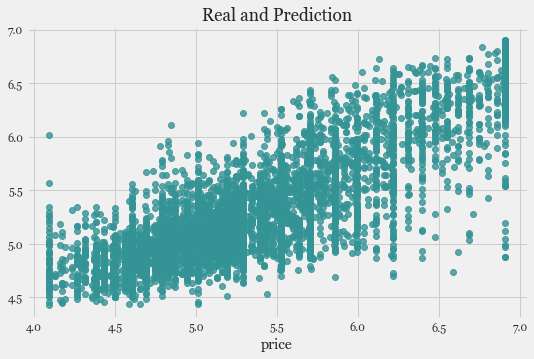

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


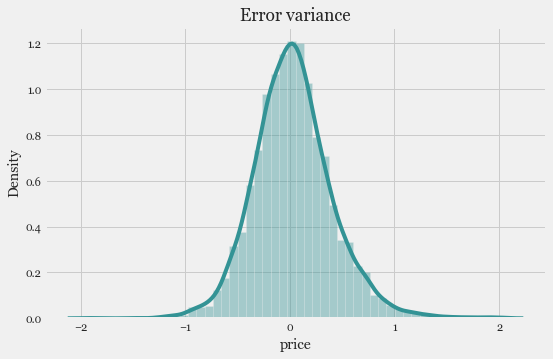

In [63]:
# fit model on train set
model_xgb1.fit(X_train_xgb_keep, y_train)

analysis(model = model_xgb1, X_train = X_train_xgb_keep, X_test = X_test_xgb_keep, y_train = y_train, y_test = y_test)

#### Hyper parameter Tuning: Test score was a bit worse

In [64]:
xgb_params = {
        'n_estimators':[500, 800, 1000, 1200],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'alpha' : [6, 8, 10, 12]
}

xgb = XGB.XGBRegressor(objective ='reg:linear')
hyper_xgb = RandomizedSearchCV(xgb, xgb_params, n_iter=5, n_jobs=-1, cv=5, verbose=3, random_state=32)
hyper_xgb.fit(X_train_xgb_keep, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62907803        nan 0.62777116        nan 0.63472329]
  warnings.warn(


[15:24:38] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validat

In [65]:
print(hyper_xgb.best_params_)

{'subsample': 1.0, 'n_estimators': 1200, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.6, 'alpha': 10}


In [66]:
model_xgb2 = XGB.XGBRegressor(objective ='reg:linear', subsample=1, n_estimators=1200, min_child_weight=15, max_depth=7, gamma=0.7, colsample_bytree=0.8, alpha=1, learning_rate=0.25, n_jobs=-1, random_state=32)

[15:24:42] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.12,0.14,0.34,0.37,0.065,0.07,0.71,0.66


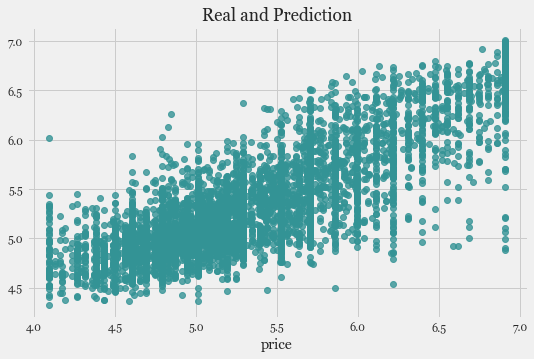

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


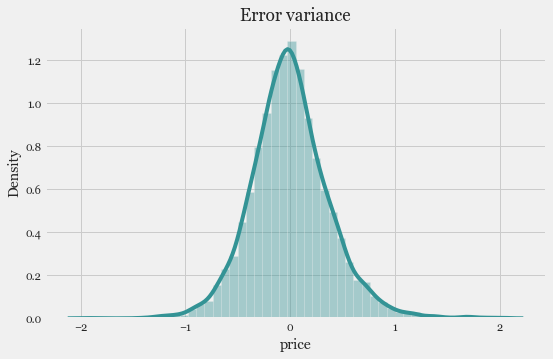

In [67]:
# fit model on train set
model_xgb2.fit(X_train_xgb_keep, y_train)

analysis(model = model_xgb2, X_train = X_train_xgb_keep, X_test = X_test_xgb_keep, y_train = y_train, y_test = y_test)

### 5. Model 3: KNN

In [68]:
model_knn = KNeighborsRegressor(n_neighbors=15, weights='uniform', algorithm='auto', leaf_size=30, p=1, n_jobs=5)

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.15,0.17,0.39,0.42,0.072,0.078,0.63,0.58


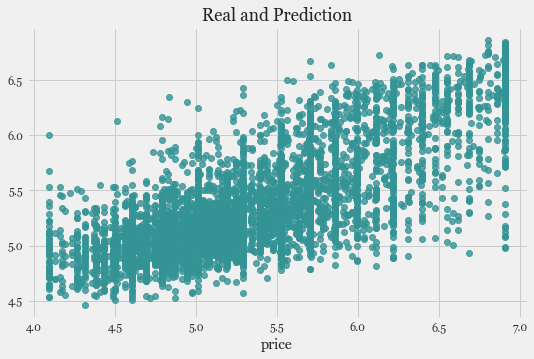

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


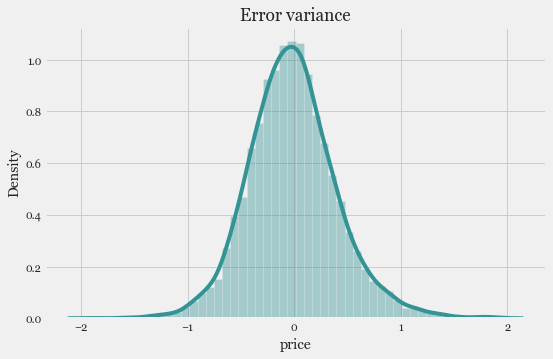

In [69]:
model_knn.fit(X_train, y_train)

analysis(model = model_knn, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [70]:
model_knn1 = KNeighborsRegressor(n_neighbors=15, weights='uniform', algorithm='auto', leaf_size=15, p=1, n_jobs=5)

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.14,0.16,0.37,0.39,0.069,0.074,0.66,0.62


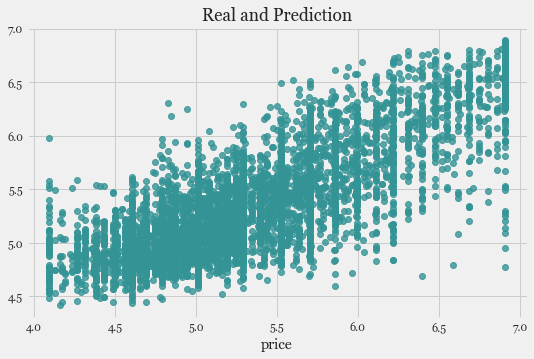

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


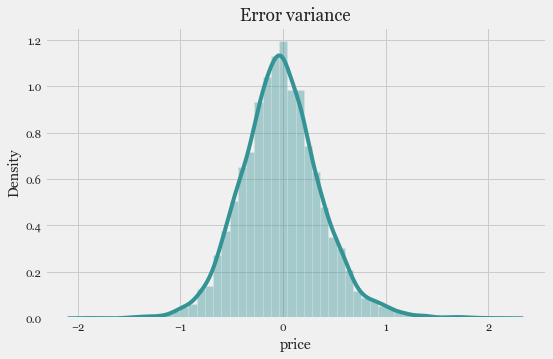

In [71]:
model_knn1.fit(X_train_keep, y_train)
analysis(model = model_knn1, X_train = X_train_keep, X_test = X_test_keep, y_train = y_train, y_test = y_test)

In [72]:
model_knn2 = KNeighborsRegressor(n_neighbors=15, weights='uniform', algorithm='auto', leaf_size=15, p=1, n_jobs=5)

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.14,0.16,0.37,0.4,0.07,0.075,0.65,0.61


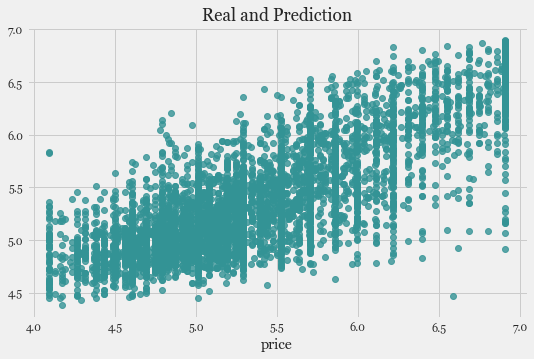

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


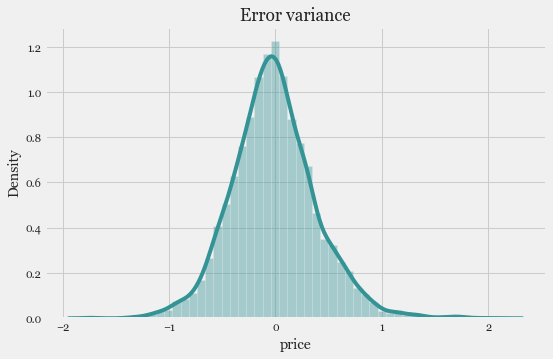

In [73]:
model_knn2.fit(X_train_xgb_keep, y_train)
analysis(model = model_knn2, X_train = X_train_xgb_keep, X_test = X_test_xgb_keep, y_train = y_train, y_test = y_test)

### 6. Model 4: SVR

In [74]:
model_svr = SVR(kernel = 'rbf')

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.08,0.14,0.28,0.37,0.053,0.07,0.8,0.66


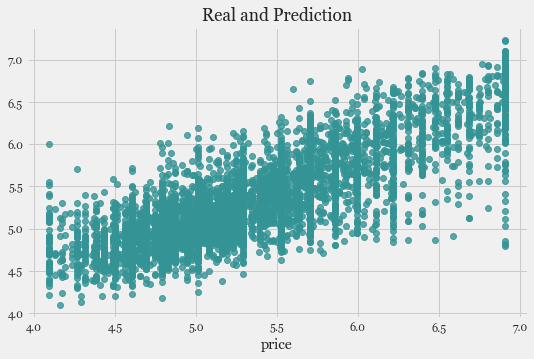

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


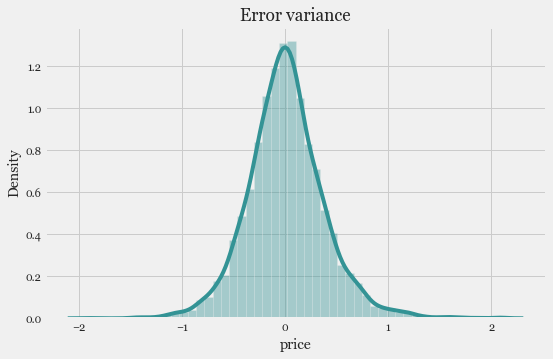

In [75]:
model_svr.fit(X_train, y_train)

analysis(model = model_svr, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [76]:
model_svr1 = SVR(kernel = 'rbf')

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.13,0.14,0.37,0.38,0.068,0.071,0.67,0.66


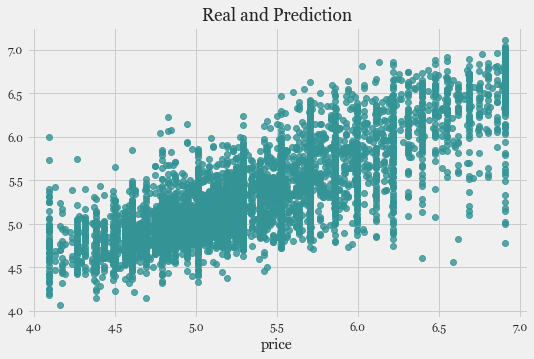

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


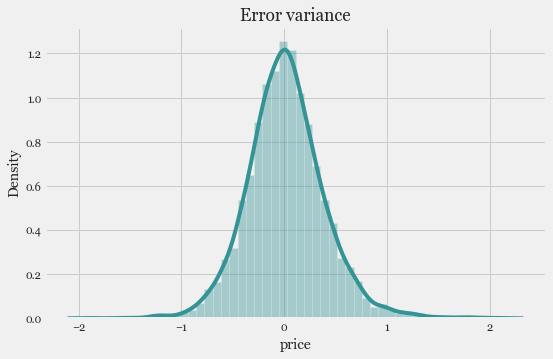

In [77]:
model_svr1.fit(X_train_keep, y_train)

analysis(model = model_svr1, X_train = X_train_keep, X_test = X_test_keep, y_train = y_train, y_test = y_test)

In [78]:
model_svr2 = SVR(kernel = 'rbf')

,MSE_train,MSE_test,RMSE_train,RMSE_test,RMSE_ratio_train,RMSE_ratio_test,R_2_train,R_2_test
0,0.14,0.15,0.37,0.38,0.07,0.072,0.66,0.64


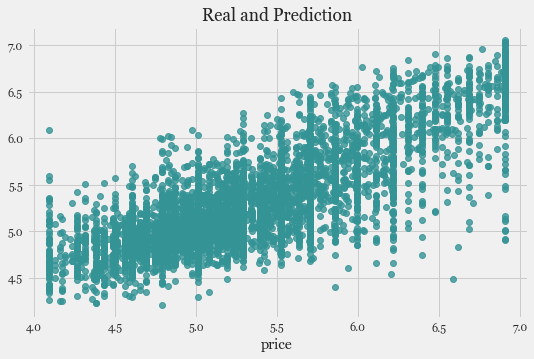

C:\Users\Wendy\anaconda3\envs\Machine_Learning\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


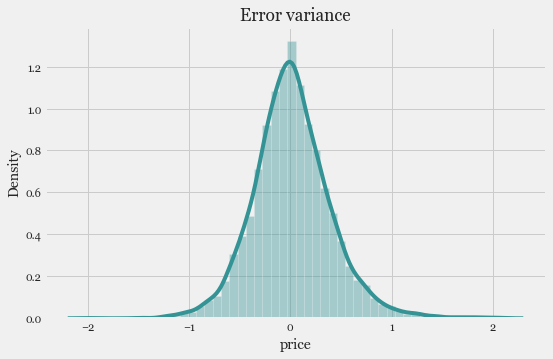

In [79]:
model_svr2.fit(X_train_xgb_keep, y_train)

analysis(model = model_svr2, X_train = X_train_xgb_keep, X_test = X_test_xgb_keep, y_train = y_train, y_test = y_test)